# 3 Logistic Regression versus Bayes Classifier
**Student ID: 35224436 | Full name: Yiming Zhang**

## Task I

### 1. Data preparation
Load the data and output some descriptive information about the data

In [1]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer(as_frame=True)

X = data.data
y = data.target
print(X.shape)
print(y.shape)
# print the first 5 rows of the data
X.head()

(569, 30)
(569,)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Data splitting with train_size=0.8

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1024)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((455, 30), (114, 30), (455,), (114,))

### 2. Bayesian Classifier 


In [3]:
from scipy.stats import multivariate_normal
import numpy as np


class BayesianClassifier:
    def __init__(self, shared_cov=True, cond_ind=True):
        self.shared_cov = shared_cov  # whether to share the covariance matrix
        self.cond_ind = cond_ind  # whether to assume conditional independence

    def fit(self, x, y):
        # get the classes and their counts
        self.classes_, class_counts = np.unique(y, return_counts=True)
        self.n_, self.p_ = x.shape  # get sample number and feature number
        self.k_ = len(self.classes_)  # [0, 1, 2, ..., k-1]

        # initialize the conditional means and covariance matrices
        self.cond_means_ = np.zeros(shape=(self.k_, self.p_))
        self.cond_covs_ = np.zeros(shape=(self.k_, self.p_, self.p_))

        # calculate the prior probabilities
        self.class_priors_ = class_counts / len(y)

        # calculate the conditional means and covariance matrices for each class
        for c in range(self.k_):
            c_rows = y == c

            self.cond_means_[c, :] = x[c_rows].mean(axis=0)

            if self.cond_ind:
                # conditional independence -> diagonal matrix
                np.fill_diagonal(self.cond_covs_[c, :, :], x[c_rows].var(axis=0))
            else:
                self.cond_covs_[c, :, :] = np.cov(x[c_rows].T, bias=True)

        if self.shared_cov:
            # calculate the shared covariance matrix
            # weighted average of the covariance matrices of each class
            shared_cov = np.moveaxis(self.cond_covs_, 0, -1).dot(self.class_priors_)
            self.cond_covs_[:] = shared_cov

        return self

    def predict_proba(self, x):
        m, _ = x.shape
        cond_probs = np.zeros(shape=(m, self.k_))
        for c in range(self.k_):
            # find p(x | c_k)
            # singular covariance matrices could happen (e.g., through inaccurate estimation)
            cond_probs[:, c] = multivariate_normal.pdf(
                x, self.cond_means_[c], self.cond_covs_[c], allow_singular=True
            )
        # find marginal probabilities p(x) by summing all the conditionals weighted by the priors
        marginal_probs = cond_probs.dot(self.class_priors_)

        # find probability vector (p(c1 | x), ..., p(ck | x)) via p(ci | x)=p(x | ci) / p(x)
        # however, p(x) might have been rounded to 0
        # thus, compute via case distinction
        probs = np.divide(
            (cond_probs * self.class_priors_).T,
            marginal_probs,
            where=marginal_probs > 0,
            out=np.zeros(shape=(self.k_, m)),
        ).T
        return probs

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

    def decision_function(self, x):
        probs = self.predict_proba(x)
        if self.k_ == 2:
            return np.log(probs[:, 1] / probs[:, 0])
        else:
            res = np.zeros(len(x), self.k_)
            for c in range(self.k_):
                res[:, c] = np.log(probs[:, c] / (1 - probs[:, c]))
            return res

    def generate(self, n, c, random_state=None):
        return multivariate_normal.rvs(
            self.cond_means_[c], self.cond_covs_[c], size=n, random_state=random_state
        )

### 3. Variants of Bayesian Classifiers
In this section, we define three types of Bayesian classifiers: the Naive Bayes variant (without shared covariance), as well as the variants with full covariance (both shared and not shared).

In [4]:
# Naive Bayes variant
naive_bayes = BayesianClassifier(shared_cov=False, cond_ind=True)
# full covariance variant with shared covariance
full_cov_shared = BayesianClassifier(shared_cov=True, cond_ind=False)
# full covariance variant with not shared covariance
full_cov_not_shared = BayesianClassifier(shared_cov=False, cond_ind=False)

### 4. Training Process
Use the training set obtained in the first step to train the three variants of Bayesian classifiers and the logistic regression model.

In [5]:
from sklearn.linear_model import LogisticRegression

# Naive Bayes variant
naive_bayes.fit(X_train, y_train)
# full covariance variant with shared covariance
full_cov_shared.fit(X_train, y_train)
# full covariance variant with not shared covariance
full_cov_not_shared.fit(X_train, y_train)
# logistic regression model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
logistic_regression = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
# logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

### 5. Evaulation Methods
In this experiment, I evaluate the performance of logistic regression and several Bayesian classifiers on the sklearn breast cancer dataset. This dataset is a binary classification problem with 30 continuous features, where the classes are relatively balanced (212 malignant and 357 benign samples).
To assess the models, I mainly adopt Accuracy and the Confusion Matrix:

- **Accuracy** is used as a global measure of performance since the class distribution is not highly imbalanced. It provides a straightforward view of how many predictions are correct overall.

- **Confusion Matrix** is included to give a more detailed picture of misclassifications, especially the number of false negatives (malignant cases predicted as benign). This helps identify the specific risks of using each classifier in a sensitive application like cancer diagnosis.

Together, these metrics provide both an overall evaluation and a class-level analysis, ensuring that the comparison captures not only the general performance but also the medical relevance of the results.

#### Evaluation utilities

In [6]:
#### Evaluation utilities

from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
from IPython.display import display


def evaluate_classifier(
    model,
    model_name,
):
    """
    model: trained classifier.
    model_name: name of the classifier.
    X_test: test samples.
    y_test: predicted test ground truth labels.
    """
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # declare metrics
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    cm = confusion_matrix(y_test, y_pred_test)

    print(f"\nEvaluation Model Name: {model_name}")
    accuracy_df = pd.DataFrame({    
        "Accuracy": [train_accuracy, test_accuracy]
    }, index=["Train", "Test"])
    display(accuracy_df)

    # confusion matrix table
    cm_df = pd.DataFrame(
        cm,
        index=["Actual 0 (malignant)", "Actual 1 (benign)"],
        columns=["Pred 0 (malignant)", "Pred 1 (benign)"],
    )
    print("Confusion Matrix:")
    display(cm_df)

    # error counts table
    counts_df = pd.DataFrame(
        {
            "False negatives": [cm[0, 1]],  #  (actual 0 -> predicted 1)
            "False positives": [cm[1, 0]],  #  (actual 1 -> predicted 0)
        }
    )
    print("Error Counts:")
    display(counts_df)

    return {
        "model_name": model_name,
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy,
        "confusion_matrix": cm,
    }


def compare_all_results(results):
    """
    Compare results across classifiers and display a summary table.
    """
    rows = []
    for r in results:
        cm = r["confusion_matrix"]
        rows.append(
            {
                "Classifier": r["model_name"],
                "Test Accuracy": r["test_accuracy"],
                "Train Accuracy": r["train_accuracy"],
                "FN (0->1)": int(cm[0, 1]),
                "FP (1->0)": int(cm[1, 0]),
            }
        )

    summary_df = pd.DataFrame(rows)
    summary_df = summary_df.sort_values(by=["Test Accuracy"], ascending=False).reset_index(
        drop=True
    )
    print("Summary across classifiers:")
    display(summary_df.round(4))

    # best models by key metrics
    best_acc = max(results, key=lambda x: (x["test_accuracy"], x["train_accuracy"]))
    print(f"Best Test Accuracy: {best_acc['model_name']} ({best_acc['test_accuracy']:.4f}); ")


# initialize a container for results
results = []

#### Evaulation process

In [7]:
# 1) Evaluate Naive Bayes
result1 = evaluate_classifier(naive_bayes, "Naive Bayes",  )
results.append(result1)



Evaluation Model Name: Naive Bayes


,Accuracy
Train,0.929670
Test,0.938596


Confusion Matrix:


,Pred 0 (malignant),Pred 1 (benign)
Actual 0 (malignant),30,7
Actual 1 (benign),0,77


Error Counts:


,False negatives,False positives
0,7,0


In [8]:
# 2) Evaluate Full Covariance (Shared)
result2 = evaluate_classifier(full_cov_shared, "Full Covariance (Shared)",  )
results.append(result2)



Evaluation Model Name: Full Covariance (Shared)


,Accuracy
Train,0.960440
Test,0.973684


Confusion Matrix:


,Pred 0 (malignant),Pred 1 (benign)
Actual 0 (malignant),34,3
Actual 1 (benign),0,77


Error Counts:


,False negatives,False positives
0,3,0


In [9]:
# 3) Evaluate Full Covariance (Not Shared)
result3 = evaluate_classifier(full_cov_not_shared, "Full Covariance (Not Shared)",  )
results.append(result3)



Evaluation Model Name: Full Covariance (Not Shared)


,Accuracy
Train,0.945055
Test,0.912281


Confusion Matrix:


,Pred 0 (malignant),Pred 1 (benign)
Actual 0 (malignant),33,4
Actual 1 (benign),6,71


Error Counts:


,False negatives,False positives
0,4,6


In [10]:
# 4) Evaluate Logistic Regression
result4 = evaluate_classifier(logistic_regression, "Logistic Regression",  )
results.append(result4)



Evaluation Model Name: Logistic Regression


,Accuracy
Train,0.991209
Test,0.973684


Confusion Matrix:


,Pred 0 (malignant),Pred 1 (benign)
Actual 0 (malignant),36,1
Actual 1 (benign),2,75


Error Counts:


,False negatives,False positives
0,1,2


#### Results presentation

In [11]:
compare_all_results(results)

Summary across classifiers:


,Classifier,Test Accuracy,Train Accuracy,FN (0->1),FP (1->0)
0,Full Covariance (Shared),0.9737,0.9604,3,0
1,Logistic Regression,0.9737,0.9912,1,2
2,Naive Bayes,0.9386,0.9297,7,0
3,Full Covariance (Not Shared),0.9123,0.9451,4,6


Best Test Accuracy: Logistic Regression (0.9737); 


### 6. Results Analysis

After comparative analysis, both **Logistic Regression** and the **Full Covariance (Shared)** Gaussian model achieved the highest test accuracy (0.9737). From a purely statistical perspective, the shared covariance model showed better generalization, with training and test accuracies closely aligned (0.9604 vs. 0.9737) and no false positives. Logistic Regression, in contrast, displayed slight overfitting (train 0.9912 vs. test 0.9737) and incurred two false positives.

However, when considering the medical context, the evaluation must prioritize false negatives (FN), since they represent **malignant tumors incorrectly classified as benign** — effectively missed cancer diagnoses. In this regard, **Logistic Regression clearly outperformed**, with only 1 FN, compared to 3 FN for the shared covariance model. Although Logistic Regression produced 2 false positives, such errors merely result in unnecessary follow-up tests, which are far less harmful than missed malignancies.

Therefore, **Logistic Regression is the best model in practice**, as it minimizes the most critical medical risk: missed diagnoses.

## Task II

### Experiment loop

In [12]:
# generate a list of training sizes
training_sizes = list(range(5, 501, 5))

# initialize a container for results
results = []

# define models list
models = [naive_bayes, full_cov_shared, full_cov_not_shared, logistic_regression]
model_names = [
    "Naive Bayes",
    "Full Covariance (Shared)",
    "Full Covariance (Not Shared)",
    "Logistic Regression",
]

# start the experiment loop
for N in training_sizes:
    for _ in range(10):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=N, shuffle=True, stratify=y
        )
        for model, model_name in zip(models, model_names):
            model.fit(X_train, y_train)
            results.append(
                {
                    "N": N,
                    "model": model_name,
                    "train_accuracy": accuracy_score(y_train, model.predict(X_train)),
                    "test_accuracy": accuracy_score(y_test, model.predict(X_test)),
                }
            )

In [13]:
# convert results to a pandas DataFrame
results_df = pd.DataFrame(results)
results_df

,N,model,train_accuracy,test_accuracy
0,5,Naive Bayes,1.000,0.652482
1,5,Full Covariance (Shared),1.000,0.372340
2,5,Full Covariance (Not Shared),1.000,0.372340
3,5,Logistic Regression,1.000,0.918440
4,5,Naive Bayes,1.000,0.673759
...,...,...,...,...
3995,500,Logistic Regression,0.990,0.956522
3996,500,Naive Bayes,0.930,0.927536
3997,500,Full Covariance (Shared),0.962,0.956522
3998,500,Full Covariance (Not Shared),0.946,0.913043


## Task III

### Plot function

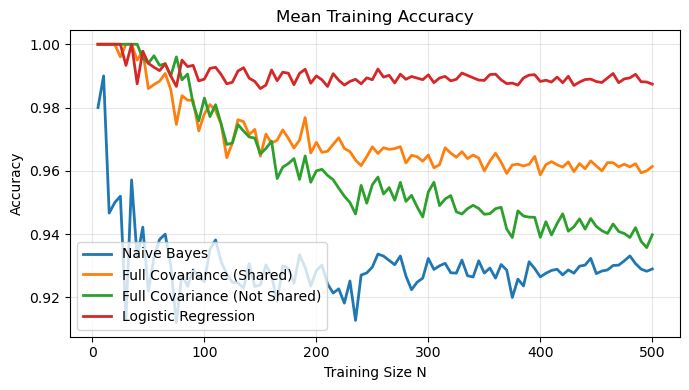

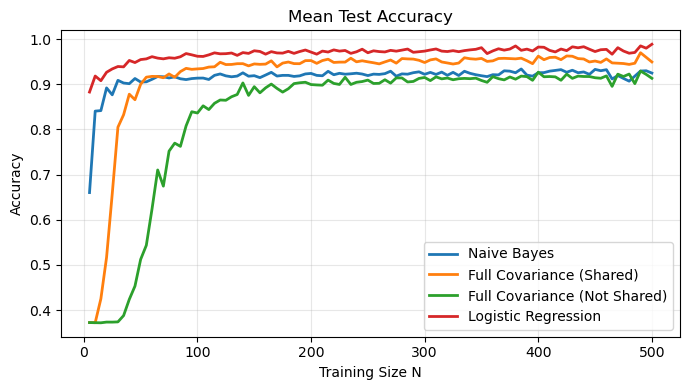

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(results)

# calculate the mean of train and test accuracy
df_mean = (
    df.groupby(["N", "model"], as_index=False)[["train_accuracy", "test_accuracy"]]
    .mean()
    .sort_values(["model", "N"])
)

models = [
    "Naive Bayes",
    "Full Covariance (Shared)",
    "Full Covariance (Not Shared)",
    "Logistic Regression",
]

# mean train accuracy plot
plt.figure(figsize=(7, 4))
for model in models:
    data = df_mean[df_mean["model"] == model]
    if data.empty:
        continue
    plt.plot(
        data["N"],
        data["train_accuracy"],
        label=model,
        linewidth=2,
    )
plt.xlabel("Training Size N")
plt.ylabel("Accuracy")
plt.title("Mean Training Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# mean test accuracy plot
plt.figure(figsize=(7, 4))
for model in models:
    data = df_mean[df_mean["model"] == model]
    if data.empty:
        continue
    plt.plot(
        data["N"],
        data["test_accuracy"],
        label=model,
        linewidth=2,
    )
plt.xlabel("Training Size N")
plt.ylabel("Accuracy")
plt.title("Mean Test Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Task IV

### a

**What happens to each classifiers train and test performance when the number of training data points is increased?**

Answer:

As the training size increases, the trends in training accuracy are as follows: both Full Covariance classifiers show a consistent downward tendency; Naive Bayes also decreases sharply at the beginning but then stabilizes; Logistic Regression decreases more slowly and eventually stabilizes as well.

For test accuracy, at the beginning both Full Covariance classifiers start with relatively low performance but improve rapidly within the 100 training size. Naive Bayes achieves a relatively high test accuracy at the start and reaches its best performance within about 40 training samples, but its maximum accuracy remains lower than that of Logistic Regression and Full Covariance (Shared). Finally, Logistic Regression performs best overall, with the highest starting accuracy and the highest final accuracy on the test set.


### b

**Which classifier is best suited when the training set is small, and which is best suited
when the training set is big?**

Answer:

For both small and  large training set, Logistic Regression achieves the best test accuracy.


### c

**Justify your observations by providing some speculations and possible reasons.**

Answer:

**Naive Bayes** performs well with small training sets (has a very high test accuarcy at the begining) because it has very few parameters to estimate and makes a strong independence assumption between features. This reduces variance but introduces high bias, limiting its maximum achievable accuracy once more data becomes available.

Both **Full Covariance (Not Shared)** and **Full Covariance (Shared)** exhibit low test accuracy with small training sets due to unstable covariance estimation. However, the Not Shared variant has a much larger number of parameters, making the problem more severe. In contrast, the Shared variant requires fewer parameters, allowing it to recover more quickly as the training size increases and eventually approach the performance of Logistic Regression.

Logistic Regression consistently achieves the highest test accuracy across all training sizes. This is because it directly models 
conditional probability without making strong distributional assumptions, allowing it to generalize well even with small datasets while maintaining the lowest bias as the training size increases.
